<a href="https://colab.research.google.com/github/silent-ai/chessboard/blob/main/nbs/chessboard_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
! pip install fastai --upgrade > /dev/null

     |████████████████████████████████| 194kB 15.6MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 


In [2]:
from fastai.vision.all import *

## Download data from github

In [3]:
from zipfile import ZipFile as unzip
path = Path('data')

with unzip(download_data('https://tinyurl.com/silentai'), 'r') as ref:
    ref.extractall(path)

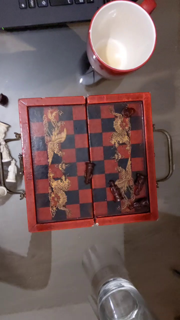

In [4]:
imgs = get_image_files(path/'images')
PILImage.create(imgs[0]).resize(size=(180, 320))

## Get annotations

In [ ]:
import json
with open(path/'annotations'/'instances_default.json') as f:
  codes = json.load(f)

In [ ]:
labels = dict((image['file_name'], anno['segmentation']) 
              for anno, image in zip(codes['annotations'], codes['images']))

In [ ]:
def get_label(f):
  points = labels[f.name][0]
  return tensor(list(zip(points[::2], points[1::2])))

In [ ]:
get_label(path/'images'/'frame80.jpg')
labels

{'frame80.jpg': [[117.44,
   536.59,
   542.03,
   421.5,
   720.0,
   804.1,
   226.31,
   973.62]],
 'frame800.jpg': [[224.75,
   398.17,
   571.58,
   572.36,
   440.94,
   1004.73,
   30.34,
   954.96]],
 'frame820.jpg': [[296.3,
   353.06,
   697.56,
   521.03,
   542.03,
   958.07,
   111.22,
   908.3]],
 'frame880.jpg': [[121.17,
   384.51,
   658.68,
   500.22,
   505.64,
   910.82,
   42.78,
   845.5]]}

## Datablock API

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_label,
    item_tfms=Resize(320),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = biwi.dataloaders(path, bs=4)
dls.show_batch(max_n=9, figsize=(8,6))

KeyError: ignored

## Train

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=1.737800812406931e-05)

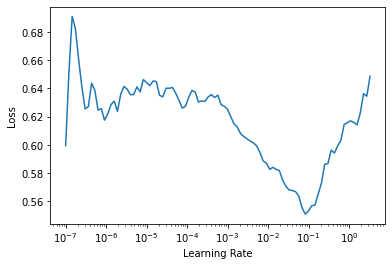

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, 10e-3)

epoch,train_loss,valid_loss,time
0,0.920554,0.588643,00:00


epoch,train_loss,valid_loss,time
0,0.727882,0.496823,00:01
1,0.706526,0.465438,00:01
2,0.678499,0.317453,00:00


In [ ]:
learn.show_results()

NameError: ignored